In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# ==========================================
# 1. CẤU HÌNH THAM SỐ (BẠN CÓ THỂ CHỈNH SỬA)
# ==========================================
INPUT_FILE = 'data/comb_PM25_wind_Hanoi_2018_v3.csv'
OUTPUT_CSV = 'SPRT_PM25_Result.csv'
OUTPUT_IMG = 'SPRT_PM25_Chart.png'

# Các giả thuyết kiểm định (đơn vị: ug/m3)
MU_0 = 25  # H0: Mức an toàn (trung bình năm)
MU_1 = 70  # H1: Mức ô nhiễm (trung bình 24h hoặc ngưỡng cảnh báo)

# Các xác suất lỗi (Error rates)
ALPHA = 0.05  # Type I error (Báo động giả) - 5%
BETA = 0.10   # Type II error (Bỏ sót sự cố) - 10%
STANDARD_LIMIT = 50
# ==========================================
# 2. XỬ LÝ DỮ LIỆU
# ==========================================
# Đọc dữ liệu
print("Đang đọc dữ liệu...")
df = pd.read_csv(INPUT_FILE)

# Chuyển đổi cột DATE sang định dạng datetime và sắp xếp
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')

# Loại bỏ các dòng thiếu dữ liệu PM2.5 (nếu có)
df = df.dropna(subset=['PM2.5'])

# Tính độ lệch chuẩn (Sigma) từ dữ liệu lịch sử
# Trong thực tế, bạn nên dùng 1 khoảng thời gian mẫu ổn định để tính sigma.
# Ở đây ta dùng toàn bộ dữ liệu để ước lượng sơ bộ.
SIGMA = df['PM2.5'].std()
print(f"Độ lệch chuẩn (Sigma) ước tính: {SIGMA:.2f}")

# ==========================================
# 3. THUẬT TOÁN SPRT (Wald's Test)
# ==========================================
# Tính các ngưỡng quyết định (Wald's thresholds)
# a: Ngưỡng trên (Bác bỏ H0 -> Chấp nhận H1: Ô nhiễm)
# b: Ngưỡng dưới (Chấp nhận H0 -> An toàn)
a = np.log((1 - BETA) / ALPHA)
b = np.log(BETA / (1 - ALPHA))

print(f"Ngưỡng trên (a): {a:.3f}")
print(f"Ngưỡng dưới (b): {b:.3f}")

# Chuẩn bị biến để lưu kết quả
llr_values = []      # Giá trị Log-Likelihood Ratio tích lũy
decisions = []       # Quyết định tại mỗi thời điểm
cum_llr = 0          # Biến tích lũy LLR

# Hệ số hằng số để tối ưu tốc độ tính toán trong vòng lặp
# Công thức LLR update: LLR += (mu1 - mu0)/sigma^2 * (x - (mu0 + mu1)/2)
term_factor = (MU_1 - MU_0) / (SIGMA**2)
term_center = (MU_0 + MU_1) / 2

print("Đang chạy thuật toán SPRT...")

for x in df['PM2.5']:
    # Cập nhật giá trị LLR
    step_val = term_factor * (x - term_center)
    cum_llr += step_val

    # Lưu giá trị hiện tại để vẽ biểu đồ
    llr_values.append(cum_llr)

    # Ra quyết định
    if cum_llr >= a:
        decisions.append('Polluted') # Kết luận: Ô nhiễm
        cum_llr = 0                  # Reset quy trình giám sát
    elif cum_llr <= b:
        decisions.append('Safe')     # Kết luận: An toàn
        cum_llr = 0                  # Reset quy trình giám sát
    else:
        decisions.append('Continue') # Chưa đủ bằng chứng, tiếp tục theo dõi

# Gán kết quả vào DataFrame
df['LLR'] = llr_values
df['Decision'] = decisions

# Lưu ra file CSV
df.to_csv(OUTPUT_CSV, index=False)
print(f"Đã lưu kết quả phân tích vào file: {OUTPUT_CSV}")

# ==========================================



Đang đọc dữ liệu...
Độ lệch chuẩn (Sigma) ước tính: 31.50
Ngưỡng trên (a): 2.890
Ngưỡng dưới (b): -2.251
Đang chạy thuật toán SPRT...
Đã lưu kết quả phân tích vào file: SPRT_PM25_Result.csv


Đang vẽ biểu đồ...
Đã lưu biểu đồ LLR vào file: SPRT_Chart_LLR_Only.png


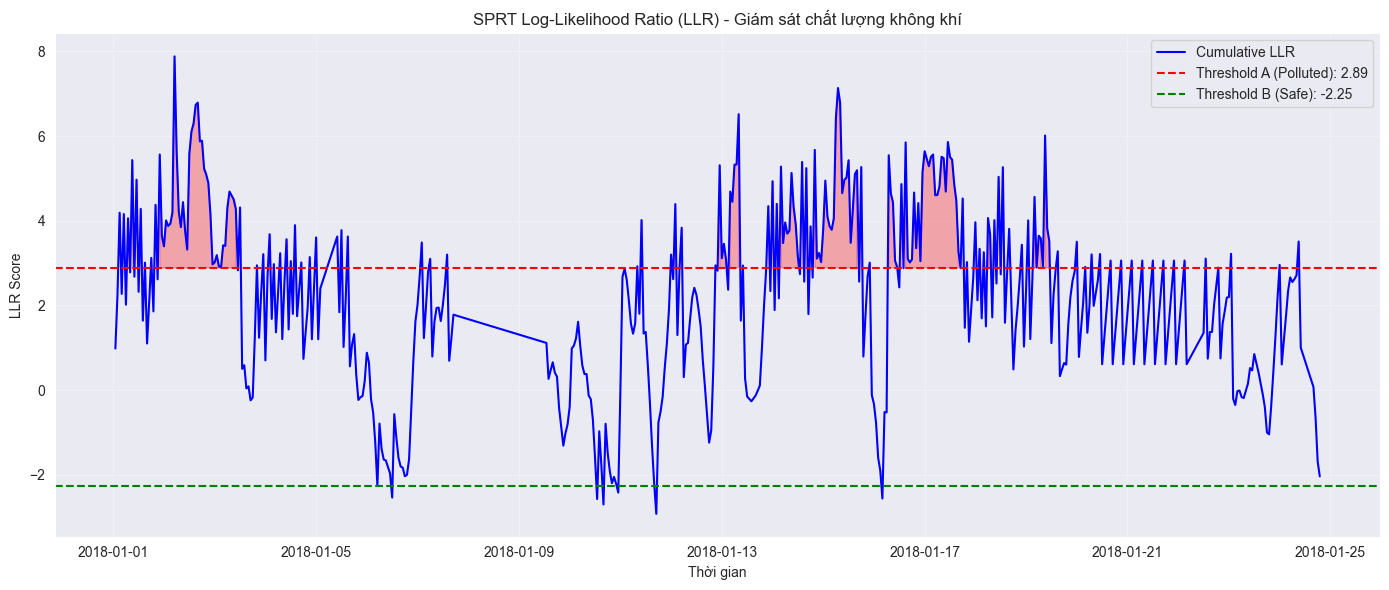

In [2]:
# ==========================================
# 4.1. VẼ BIỂU ĐỒ SPRT (LLR)
# ==========================================
# 4. VẼ ĐỒ THỊ (VISUALIZATION)
# ==========================================
print("Đang vẽ biểu đồ...")

# Để biểu đồ dễ nhìn, ta chỉ vẽ 500 điểm dữ liệu đầu tiên (khoảng 20 ngày)
# Nếu muốn vẽ hết, bạn bỏ dòng [0:500] bên dưới
plot_df = df.iloc[0:500]
plt.figure(figsize=(14, 6)) # Tạo khung hình mới

# Vẽ đường LLR tích lũy
plt.plot(plot_df['DATE'], plot_df['LLR'], label='Cumulative LLR', color='blue', linewidth=1.5)

# Vẽ các đường ngưỡng
plt.axhline(y=a, color='red', linestyle='--', label=f'Threshold A (Polluted): {a:.2f}')
plt.axhline(y=b, color='green', linestyle='--', label=f'Threshold B (Safe): {b:.2f}')

# Tô màu vùng vượt ngưỡng để dễ nhìn
plt.fill_between(plot_df['DATE'], a, plot_df['LLR'], where=(plot_df['LLR'] >= a), color='red', alpha=0.3)
plt.fill_between(plot_df['DATE'], b, plot_df['LLR'], where=(plot_df['LLR'] <= b), color='green', alpha=0.3)

# Trang trí biểu đồ
plt.title('SPRT Log-Likelihood Ratio (LLR) - Giám sát chất lượng không khí')
plt.ylabel('LLR Score')
plt.xlabel('Thời gian')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Lưu và hiển thị
plt.savefig('SPRT_Chart_LLR_Only.png')
print("Đã lưu biểu đồ LLR vào file: SPRT_Chart_LLR_Only.png")
plt.show()

Đã lưu biểu đồ PM2.5 vào file: SPRT_Chart_PM25_Only.png


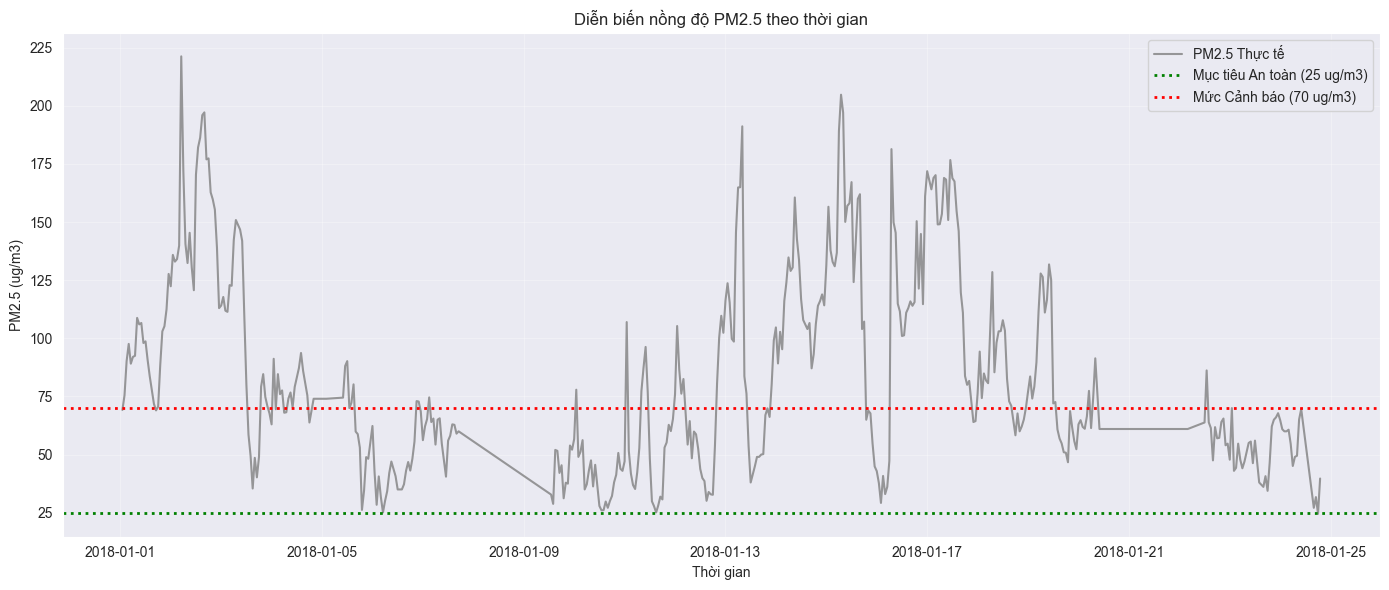

In [3]:
# ==========================================
# 4.2. VẼ BIỂU ĐỒ PM2.5 THỰC TẾ
# ==========================================
plt.figure(figsize=(14, 6)) # Tạo khung hình mới

# Vẽ dữ liệu PM2.5
plt.plot(plot_df['DATE'], plot_df['PM2.5'], label='PM2.5 Thực tế', color='gray', alpha=0.8)

# Vẽ các đường tham chiếu nồng độ
plt.axhline(y=MU_0, color='green', linestyle=':', linewidth=2, label=f'Mục tiêu An toàn ({MU_0} ug/m3)')
plt.axhline(y=MU_1, color='red', linestyle=':', linewidth=2, label=f'Mức Cảnh báo ({MU_1} ug/m3)')

# Trang trí biểu đồ
plt.title('Diễn biến nồng độ PM2.5 theo thời gian')
plt.ylabel('PM2.5 (ug/m3)')
plt.xlabel('Thời gian')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Lưu và hiển thị
plt.savefig('SPRT_Chart_PM25_Only.png')
print("Đã lưu biểu đồ PM2.5 vào file: SPRT_Chart_PM25_Only.png")
plt.show()

In [4]:


# --- Load dữ liệu và Xử lý ---
try:
    # Load file nếu có
    df = pd.read_csv('SPRT_PM25_Result.csv')
    df['DATE'] = pd.to_datetime(df['DATE'])
except:
    # Nếu biến df đã tồn tại trong bộ nhớ từ các bước trước thì bỏ qua lỗi
    print("Sử dụng biến df đang có trong bộ nhớ.")
    pass

# 1. Tạo Ground Truth (Chân lý dựa trên MA 24h)
df['MA_24h'] = df['PM2.5'].rolling(window=24, min_periods=1).mean()
df['True_Label'] = np.where(df['MA_24h'] >= 50, 1, 0) # 1: Ô nhiễm, 0: An toàn

# 2. Chuẩn hóa nhãn SPRT (Xử lý trạng thái 'Continue')
# Map: Polluted->1, Safe->0, Continue->NaN
df['SPRT_Label_Raw'] = df['Decision'].map({'Polluted': 1, 'Safe': 0, 'Continue': np.nan})

# Dùng ffill để giữ trạng thái trước đó nếu gặp 'Continue'
df['SPRT_Label_Final'] = df['SPRT_Label_Raw'].ffill().fillna(0).astype(int)

print("Đã xử lý xong dữ liệu!")
df[['DATE', 'PM2.5', 'Decision', 'SPRT_Label_Final', 'True_Label']].head()

Đã xử lý xong dữ liệu!


,DATE,PM2.5,Decision,SPRT_Label_Final,True_Label
0,2018-01-01 01:00:00,69.2,Continue,0,1
1,2018-01-01 02:00:00,75.5,Continue,0,1
2,2018-01-01 03:00:00,90.2,Polluted,1,1
3,2018-01-01 04:00:00,97.6,Continue,1,1
4,2018-01-01 05:00:00,89.1,Polluted,1,1


=== BÁO CÁO CHI TIẾT ===
              precision    recall  f1-score   support

     An toàn       0.96      0.94      0.95      5958
     Ô nhiễm       0.85      0.90      0.87      2158

    accuracy                           0.93      8116
   macro avg       0.90      0.92      0.91      8116
weighted avg       0.93      0.93      0.93      8116



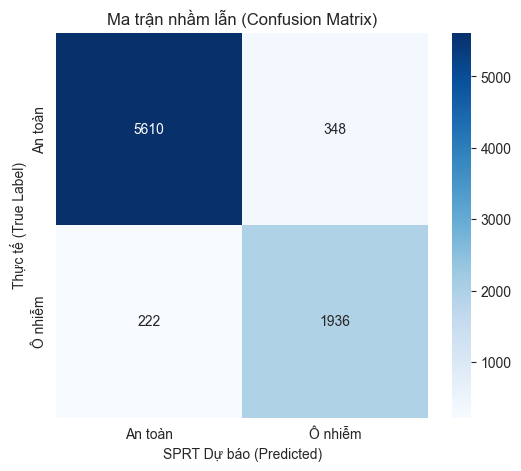

In [5]:
# --- Báo cáo chỉ số ---
print("=== BÁO CÁO CHI TIẾT ===")
print(classification_report(df['True_Label'], df['SPRT_Label_Final'], target_names=['An toàn', 'Ô nhiễm']))

# --- Vẽ Ma trận nhầm lẫn ---
cm = confusion_matrix(df['True_Label'], df['SPRT_Label_Final'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['An toàn', 'Ô nhiễm'],
            yticklabels=['An toàn', 'Ô nhiễm'])
plt.title('Ma trận nhầm lẫn (Confusion Matrix)')
plt.ylabel('Thực tế (True Label)')
plt.xlabel('SPRT Dự báo (Predicted)')
plt.show()

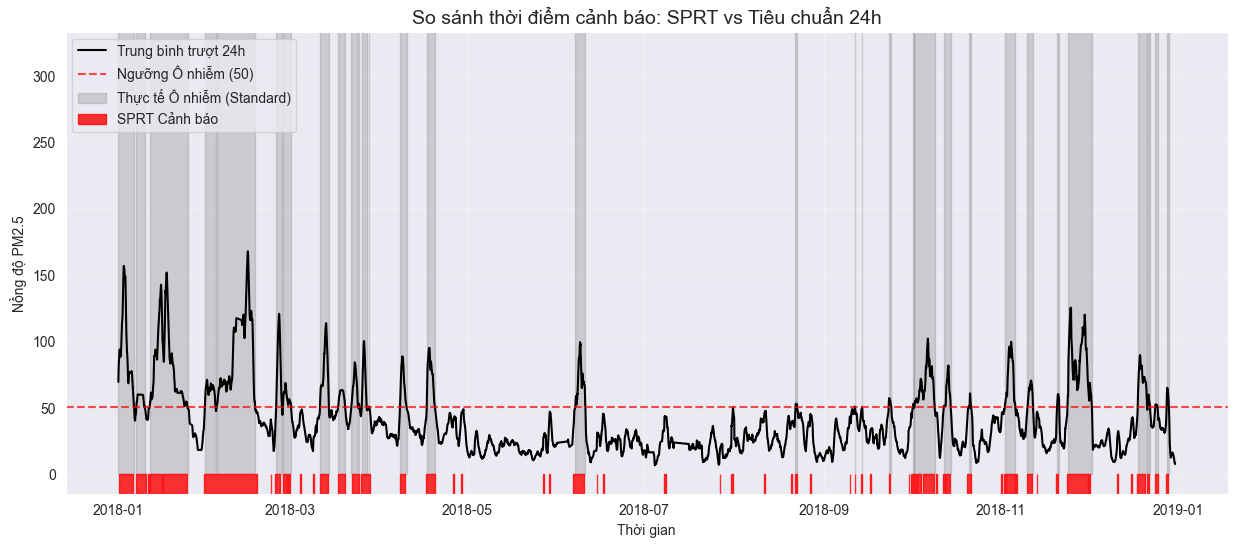

In [6]:
# --- Vẽ biểu đồ Time Series ---
plt.figure(figsize=(15, 6))

# 1. Đường trung bình 24h (Dùng làm chuẩn so sánh)
plt.plot(df['DATE'], df['MA_24h'], label='Trung bình trượt 24h', color='black', linewidth=1.5)

# 2. Đường ngưỡng 50
plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Ngưỡng Ô nhiễm (50)')

# 3. Tô màu vùng THỰC TẾ ô nhiễm (Màu xám)
plt.fill_between(df['DATE'], 0, df['PM2.5'].max() + 50,
                 where=(df['True_Label'] == 1),
                 color='gray', alpha=0.3, label='Thực tế Ô nhiễm (Standard)')

# 4. Tô màu vùng SPRT CẢNH BÁO (Màu đỏ dưới đáy)
# Vẽ một dải màu đỏ nhỏ phía dưới trục hoành để đánh dấu khi SPRT báo động
bottom_lim = -15
plt.fill_between(df['DATE'], bottom_lim, 0,
                 where=(df['SPRT_Label_Final'] == 1),
                 color='red', alpha=0.8, label='SPRT Cảnh báo')

# Trang trí
plt.ylim(bottom_lim, df['PM2.5'].max() + 10)
plt.title('So sánh thời điểm cảnh báo: SPRT vs Tiêu chuẩn 24h', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Nồng độ PM2.5')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.show()